## Here lets try to get some data from the alfven modes and train a few autoencoders on them to see if they capture any structure in the latent layer

In [1]:
using AlfvenDetectors
using PyPlot
using Flux
using CuArrays  # for GPU runs
using ValueHistories
using BSON: @save, @load
using HDF5

┌ Info: Recompiling stale cache file /home/vit/.julia/compiled/v1.1/AlfvenDetectors/VqnlF.ji for AlfvenDetectors [5e555b46-3391-11e9-1beb-e9498a8cd634]
└ @ Base loading.jl:1184


What we are doing is unsupervised training on columns of the magnitude squared coherence time histograms. 

### Collect the data

Use shot #10370 and #11960 and several coil couples. Select only some timeslices, normalize data

In [2]:
host = gethostname()
if occursin("vit", host)
    datapath = "/home/vit/vyzkum/alfven/cdb_data/original_data/"
else
    datapath = "/home/skvara/work/alfven/cdb_data/original_data/"
end

"/home/vit/vyzkum/alfven/cdb_data/original_data/"

In [3]:
function get_msc_array(datapath, shot, coil, timelim = [1.0, 1.25])
    h5data = h5open(joinpath(datapath,"$(shot).h5"), "r")
    t = Float32.(read(h5data, "t"))
    msc = Float32.(read(h5data, "cxy$coil"))
    f = Float32.(read(h5data, "f"))    
    tinds = timelim[1] .<= t .<= timelim[2]
    return msc[:,tinds], t[tinds], f 
end

get_msc_array (generic function with 2 methods)

In [4]:
msc, t, f = get_msc_array(datapath, 11096, 18)

(Float32[0.953081 0.988718 … 0.969359 0.991565; 0.960025 0.987471 … 0.969421 0.989726; … ; 0.135501 0.00779018 … 0.0905129 0.0741393; 0.00198782 0.00124353 … 0.132843 0.0319265], Float32[1.00244, 1.00525, 1.00806, 1.01087, 1.01369, 1.0165, 1.01931, 1.02213, 1.02494, 1.02775  …  1.22462, 1.22744, 1.23025, 1.23306, 1.23588, 1.23869, 1.2415, 1.24431, 1.24713, 1.24994], Float32[0.0, 1953.13, 3906.25, 5859.38, 7812.5, 9765.63, 11718.8, 13671.9, 15625.0, 17578.1  …  9.82422e5, 984375.0, 9.86328e5, 9.88281e5, 9.90234e5, 9.92188e5, 9.94141e5, 9.96094e5, 9.98047e5, 1.0e6])

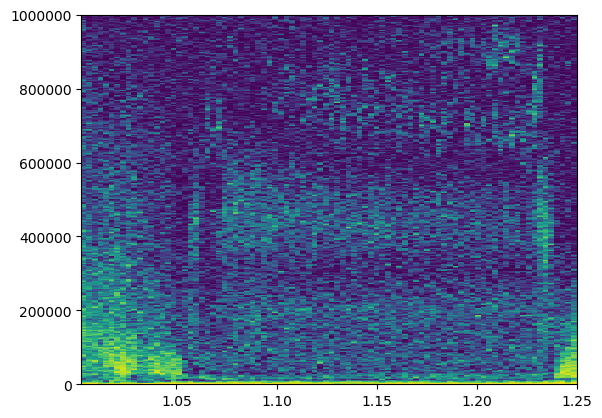

PyObject <matplotlib.collections.QuadMesh object at 0x7f354a3a4710>

In [5]:
pcolormesh(t,f,msc)

In [6]:
function collect_msc(datapath, shot, coils)
    datalist = map(x-> get_msc_array(datapath, shot, x), coils)
    return hcat([x[1] for x in datalist]...), datalist[1][3]
end

collect_msc (generic function with 1 method)

In [7]:
shots_coils = [
#    [10370, [12, 15, 17, 20]],
    [10370, [12, 20]],
#    [11096, [11, 8, 17, 20]]
    [11096, [11, 8, 20]]
]
datalist = map(x->collect_msc(datapath, x[1], x[2]), shots_coils)
data, f = hcat([x[1] for x in datalist]...), datalist[1][2]

(Float32[0.918668 0.881605 … 0.908824 0.920963; 0.914609 0.879044 … 0.875875 0.849385; … ; 0.00910574 0.328996 … 0.0584963 0.0771319; 0.0011798 0.310406 … 0.192278 0.0363167], Float32[0.0, 1953.13, 3906.25, 5859.38, 7812.5, 9765.63, 11718.8, 13671.9, 15625.0, 17578.1  …  9.82422e5, 984375.0, 9.86328e5, 9.88281e5, 9.90234e5, 9.92188e5, 9.94141e5, 9.96094e5, 9.98047e5, 1.0e6])

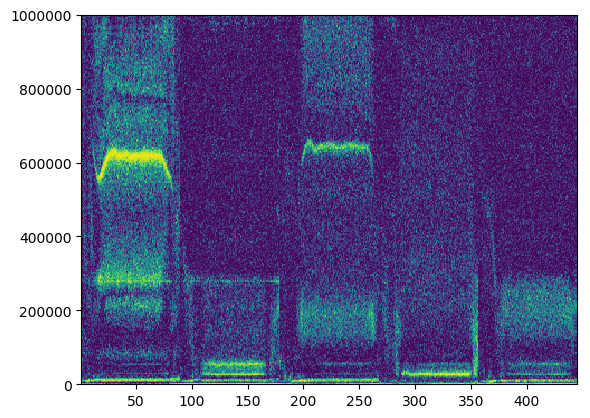

PyObject <matplotlib.collections.QuadMesh object at 0x7f3519dba160>

In [8]:
pcolormesh(1:size(data,2), f, data)

### Now that we have the data, construct a TSVAE

Larger dimension of middle layer is beneficial, but improvement from 10 to 20 is much alrger than from 20 to 200.

Reconstruction works even with zdim = 2 although there are some artifacts.

## Basic training seems to work, now test the GPU version

In [19]:
# convert to CuArrays
zdim = 2
N = size(data,1)
verb = false
cudata = data |> gpu
model = AlfvenDetectors.TSVAE(N, zdim, 2) |> gpu
train_history = (MVHistory(), MVHistory())
nepochs = 100
batchsize = Int(size(data,2)/5)
cbit = 1

1

In [20]:
@info "Training a large GPU model with less epochs in more iterations"
# clear cache
for i in 1:5
    @time AlfvenDetectors.fit!(model, cudata, batchsize, nepochs;
        cbit = cbit, history = train_history, verb = verb)
    # clear cache
    GC.gc()
end

┌ Info: Training a large GPU model with less epochs in more iterations
└ @ Main In[20]:1


  7.792032 seconds (16.70 M allocations: 555.539 MiB, 2.53% gc time)
  7.389327 seconds (16.72 M allocations: 555.963 MiB, 2.64% gc time)
  7.380833 seconds (16.72 M allocations: 556.102 MiB, 2.65% gc time)
  7.422198 seconds (16.72 M allocations: 555.905 MiB, 2.62% gc time)
  7.426197 seconds (16.72 M allocations: 556.149 MiB, 2.62% gc time)


In [21]:
@info "GPU model(data) timing"
@time model(cudata);

  0.001139 seconds (723 allocations: 32.234 KiB)


┌ Info: GPU model(data) timing
└ @ Main In[21]:1


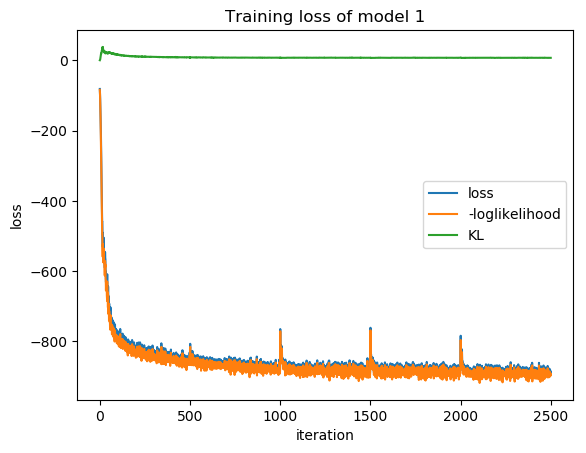

PyObject <matplotlib.legend.Legend object at 0x7f3518d0d2e8>

In [22]:
figure()
plot(get(train_history[1], :loss)...,label = "loss")
plot(get(train_history[1], :loglikelihood)..., label="-loglikelihood")
plot(get(train_history[1], :KL)..., label="KL")
title("Training loss of model 1")
xlabel("iteration")
ylabel("loss")
legend()

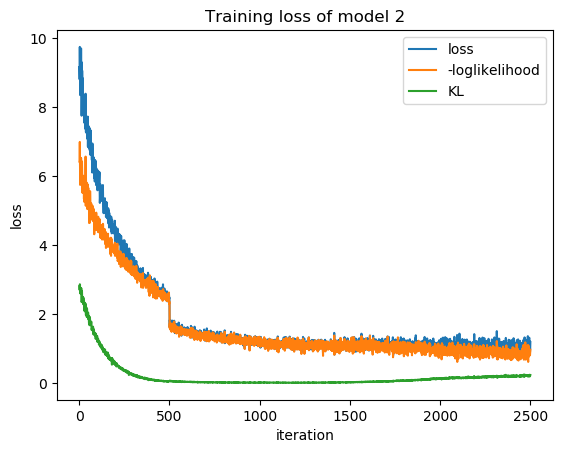

PyObject <matplotlib.legend.Legend object at 0x7f3518c7a5f8>

In [23]:
figure()
plot(get(train_history[2], :loss)...,label = "loss")
plot(get(train_history[2], :loglikelihood)..., label="-loglikelihood")
plot(get(train_history[2], :KL)..., label="KL")
title("Training loss of model 2")
xlabel("iteration")
ylabel("loss")
legend()

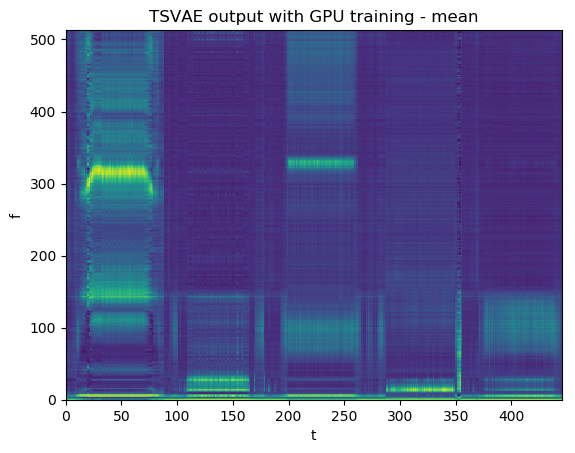

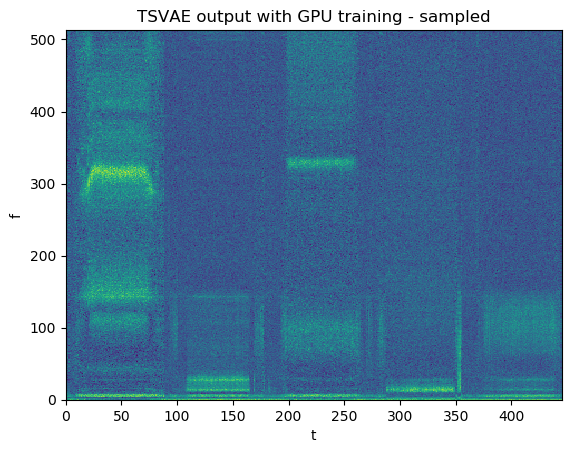

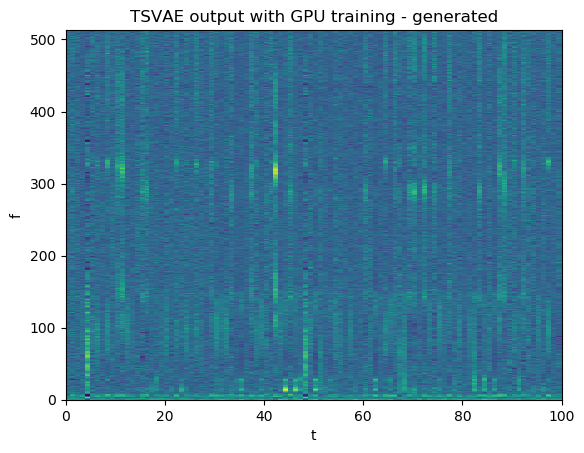

PyObject Text(24.000000000000007, 0.5, 'f')

In [37]:
cpumodel = model |> cpu
figure()
rdata = cpumodel(data).data

pcolormesh(AlfvenDetectors.mu_scalarvar(rdata))
title("TSVAE output with GPU training - mean")
xlabel("t")
ylabel("f")

figure()
pcolormesh(AlfvenDetectors.samplenormal_scalarvar(rdata))
title("TSVAE output with GPU training - sampled")
xlabel("t")
ylabel("f")

figure()
gendata = AlfvenDetectors.sample(cpumodel,100).data
pcolormesh(gendata)
title("TSVAE output with GPU training - generated")
xlabel("t")
ylabel("f")


Check further memory allocation for GPUs

## In this part, lets try to see some sort of structure in the latent code

In [38]:
# save/load a pretrained model
cpumodel = model |> cpu
f = "tsvae_model.bson"
if !isfile(f) 
    @save f cpumodel
else
    @load f cpumodel
end

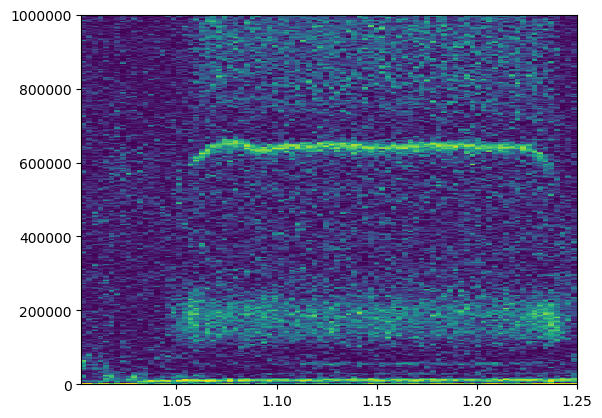

PyObject <matplotlib.collections.QuadMesh object at 0x7f35184305c0>

In [39]:
X1, t1, f1 = get_msc_array(datapath, 11096, 11)
pcolormesh(t1, f1, X1)

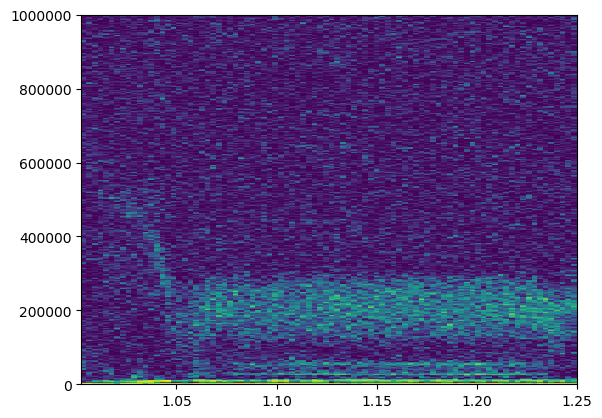

PyObject <matplotlib.collections.QuadMesh object at 0x7f3518406198>

In [40]:
X0, t0, f0 = get_msc_array(datapath, 11096, 20)
pcolormesh(t0, f0, X0)

In [49]:
Xα = X1[:,1.06.<=t1.<=1.22]
zα = AlfvenDetectors.samplenormal(cpumodel.m1.encoder(Xα).data)
z1 = AlfvenDetectors.samplenormal(cpumodel.m1.encoder(X1).data)
z0 = AlfvenDetectors.samplenormal(cpumodel.m1.encoder(X0).data)

2×89 Array{Float32,2}:
 1.1827    1.17774   1.00456   0.941759  …  0.395914  0.316331  0.542904
 0.970161  0.947063  0.911122  0.960276     1.49361   1.55012   1.24319 

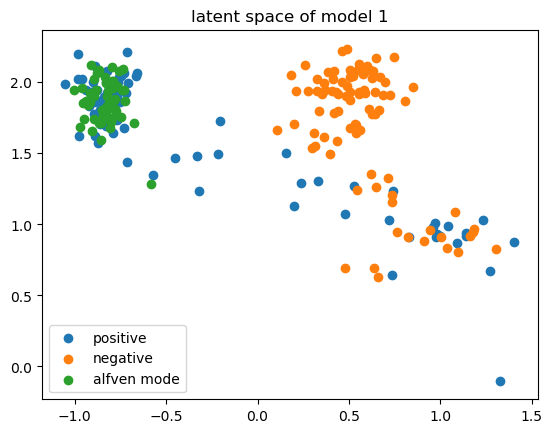

PyObject <matplotlib.legend.Legend object at 0x7f3518292908>

In [57]:
figure()
scatter(z1[1,:], z1[2,:], label = "positive")
scatter(z0[1,:], z0[2,:], label = "negative")
scatter(zα[1,:], zα[2,:], label = "alfven mode")
title("latent space of model 1")
legend()

Also, lets checkout the latent code in the second model.

In [59]:
uα = cpumodel.m2.encoder(zα).data
u1 = cpumodel.m2.encoder(z1).data
u0 = cpumodel.m2.encoder(z0).data

4×89 Array{Float32,2}:
  0.0220562   0.0216507   0.0155374   0.013969  …  -0.000602119   0.00370374
 -0.409296   -0.40273    -0.303743   -0.278348     -0.0424103    -0.112131  
  0.534155    0.534181    0.534573    0.534673      0.535608      0.535331  
 -0.322387   -0.318856   -0.265623   -0.251966     -0.125086     -0.16258   

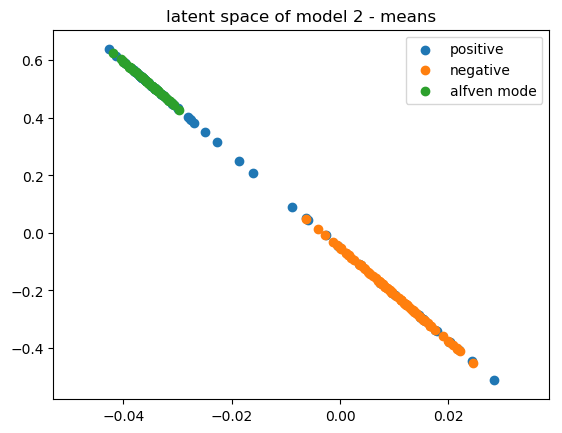

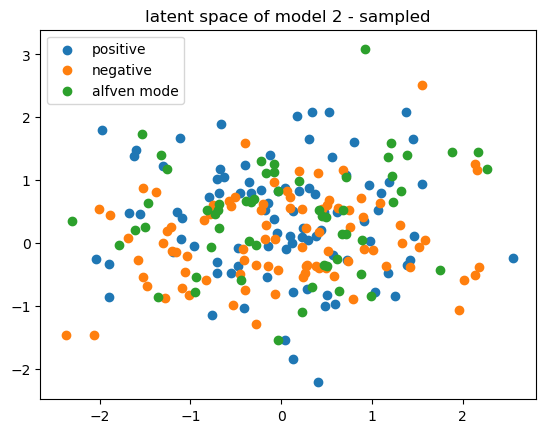

PyObject Text(0.5, 1.0, 'latent space of model 2 - sampled')

In [60]:
figure()
scatter(u1[1,:], u1[2,:], label = "positive")
scatter(u0[1,:], u0[2,:], label = "negative")
scatter(uα[1,:], uα[2,:], label = "alfven mode")
title("latent space of model 2 - means")
legend()

su1 = AlfvenDetectors.samplenormal(u1)
su0 = AlfvenDetectors.samplenormal(u0)
suα = AlfvenDetectors.samplenormal(uα)
figure()
scatter(su1[1,:], su1[2,:], label = "positive")
scatter(su0[1,:], su0[2,:], label = "negative")
scatter(suα[1,:], suα[2,:], label = "alfven mode")
legend()
title("latent space of model 2 - sampled")

